In [1]:
import torch
import torch.nn as nn
import math
import joblib

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, lr_scheduler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import joblib
import numpy as np
import random as rd
import soundfile as sf

In [2]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [23]:
S = 1
dataset_type = 'bach'

if dataset_type == 'bach':
    datas = joblib.load("/kaggle/input/holedbach/jsb1-li-train.pkl")
    X = datas['X']
    X = np.array(X)[:, None, 10:90, :]
else:
    datas = joblib.load("/kaggle/input/ms2-big1-dataset/MS2_big1_dataset.pkl")
    X = flatten(datas)
    X = np.array(X)[:, None, :, :]
print(X.shape)

"""datas_test = joblib.load("/kaggle/input/musescoremidi2rolls1/MS2_div4_dataset.pkl")
X_test = datas_test['X']
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]) # to 1 channel
X_test = X_test[:, :, 30:80, :]"""
from torch.utils.data import DataLoader

dataloader = DataLoader(X, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


(2604, 1, 80, 100)


device(type='cuda')

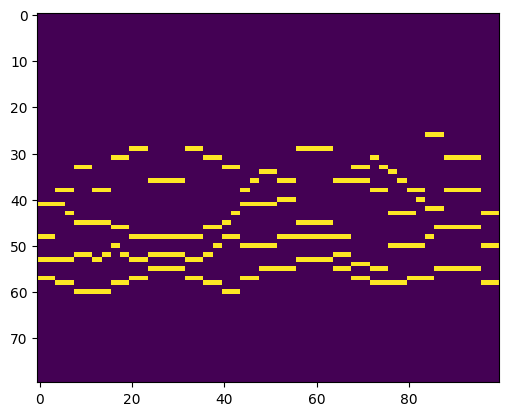

In [24]:
plt.imshow(next(iter(X))[0])

In [25]:
# ONLY RELATIVE
import torch
import torch.nn as nn
import math


class RelativeSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.scale = math.sqrt(self.head_dim)

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.rel_pos_emb = nn.Embedding(2 * max_len - 1, self.head_dim)

    def forward(self, x, _, __, attn_mask=None):
        B, T, D = x.size()
        q = self.q_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        rel_positions = torch.arange(T, device=x.device).view(1, -1) - torch.arange(T, device=x.device).view(-1, 1)
        rel_positions += T - 1 
        rel_pos_emb = self.rel_pos_emb(rel_positions) 

        # Compute attention scores
        content_scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale 
        rel_scores = torch.einsum("bhid,ijd->bhij", q, rel_pos_emb) / self.scale # i did not made this 

        scores = content_scores + rel_scores

        if attn_mask is not None:
            scores += attn_mask.unsqueeze(0).unsqueeze(0) # probably ineff.

        attn_weights = torch.softmax(scores, dim=-1) 
        attn_output = torch.matmul(attn_weights, v)  
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, D)

        return self.out_proj(attn_output), _


class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, max_len, dropout=0.2, att_type=0):
        super().__init__()
        self.self_attn = RelativeSelfAttention(d_model, n_heads, max_len)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        attn_output = self.self_attn(x, attn_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_layers, seq_len, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, max_len=seq_len, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.output_proj = nn.Linear(d_model, input_dim)
        self.sigmoid = nn.Sigmoid()

    def generate_mask(self, seq_len):
        # Causal mask: (seq_len, seq_len)
        return torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)

    def forward(self, x):
        x = self.input_proj(x)
        mask = self.generate_mask(x.size(1)).to(x.device)
        for layer in self.layers:
            x = layer(x, attn_mask=mask)
        x = self.output_proj(x)
        return self.sigmoid(x)


In [35]:
# RELATIVE & NON

import torch
import torch.nn as nn
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=128):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # dim 2i
        pe[:, 1::2] = torch.cos(position * div_term)  # dim 2i+1
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


class DecoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.2, attention_type=0):
        super().__init__()
        if attention_type == 0:
            self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        else:
            self.self_attn = RelativeSelfAttention(d_model, n_heads, max_len=100)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask=None):
        attn_output, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderOnlyTransformer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_layers, seq_len, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=seq_len)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, n_heads, d_ff, dropout, attention_type=0)
            for i in range(n_layers)
        ])
        self.output_proj = nn.Linear(d_model, input_dim)
        self.sigmoid = nn.Sigmoid()

    def generate_mask(self, seq_len):
        # Causal mask: (seq_len, seq_len)
        return torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        mask = self.generate_mask(x.size(1)).to(x.device)
        for layer in self.layers:
            x = layer(x, attn_mask=mask)
        x = self.output_proj(x)
        return x


In [38]:
model = DecoderOnlyTransformer(80, 512, 2, 2048, 25, 100, 0.1).to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
total_params = sum(p.numel() for p in model.parameters())
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([100], device=device))
# criterion = nn.BCELoss(pos_weight=torch.tensor([10], device=device))

#criterion = nn.L1Loss()

print(f"Number of parameters: {total_params:_}")

Number of parameters: 78_892_112


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [104]:
from tqdm import tqdm
dataloader = DataLoader(X, batch_size=8, shuffle=True)

for epoch in tqdm(range(400)):
    for i, batch in enumerate(dataloader):
        #print(batch.shape)
        batch = batch.permute(0, 1, 3, 2).squeeze(1).float().to(device)
        batch[batch > 0] = 1
        
        inputs = batch[:, :-1, :]
        label = batch[:, 1:, :]
        
        output = model(inputs)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        """if i % 200 == 0:
            print(loss.item())
            with torch.no_grad():
                plt.imshow(output[0].permute(1, 0).cpu())
                plt.show()"""
    if epoch % 5 == 0:
        print(loss.item())

  0%|          | 1/400 [00:29<3:15:05, 29.34s/it]

0.0194795411080122


  2%|▏         | 6/400 [02:55<3:12:23, 29.30s/it]

0.011866849847137928


  3%|▎         | 11/400 [05:22<3:09:54, 29.29s/it]

0.01992218755185604


  4%|▍         | 16/400 [07:48<3:07:16, 29.26s/it]

0.026678819209337234


  5%|▌         | 21/400 [10:14<3:04:45, 29.25s/it]

0.012393305078148842


  6%|▋         | 26/400 [12:40<3:02:18, 29.25s/it]

0.02488141879439354


  8%|▊         | 31/400 [15:07<3:00:00, 29.27s/it]

0.029800686985254288


  9%|▉         | 36/400 [17:33<2:57:36, 29.28s/it]

0.02736944891512394


 10%|█         | 41/400 [20:00<2:55:18, 29.30s/it]

0.016532933339476585


 12%|█▏        | 46/400 [22:26<2:52:53, 29.30s/it]

0.006741334218531847


 13%|█▎        | 51/400 [24:53<2:50:21, 29.29s/it]

0.03703108802437782


 14%|█▍        | 56/400 [27:19<2:47:51, 29.28s/it]

0.04916844889521599


 15%|█▌        | 61/400 [29:45<2:45:28, 29.29s/it]

0.014628224074840546


 16%|█▋        | 66/400 [32:12<2:42:59, 29.28s/it]

0.00957529153674841


 18%|█▊        | 71/400 [34:38<2:40:35, 29.29s/it]

0.013408164493739605


 19%|█▉        | 76/400 [37:05<2:38:06, 29.28s/it]

0.019162997603416443


 20%|██        | 81/400 [39:31<2:35:40, 29.28s/it]

0.017728818580508232


 22%|██▏       | 86/400 [41:57<2:33:15, 29.29s/it]

0.022353220731019974


 23%|██▎       | 91/400 [44:24<2:30:48, 29.28s/it]

0.007630960084497929


 24%|██▍       | 96/400 [46:50<2:28:21, 29.28s/it]

0.008782454766333103


 24%|██▍       | 98/400 [48:16<2:28:46, 29.56s/it]


KeyboardInterrupt: 

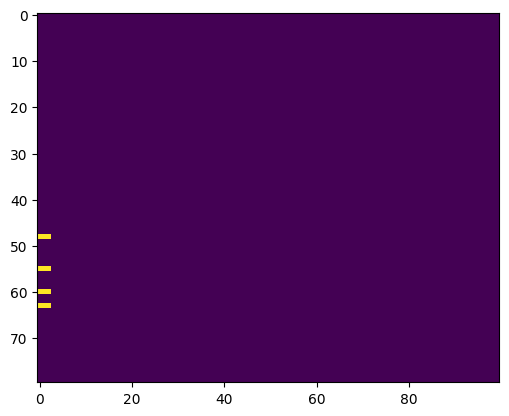

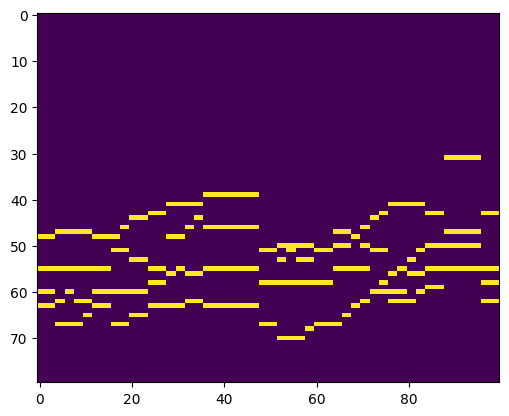

In [145]:
L = 3
seedi = next(iter(X[2311:]))
seeder = seedi.copy()
seeder[0, :, L:] = 0
plt.imshow(seeder[0])
plt.show()
plt.imshow(seedi[0])
plt.show()

In [136]:
@torch.no_grad()
# TODO: Implement a non Deterministic sampling, or a k-larger sampling (for bach chorales 4-largest is mandatory)
def autoregressive_sample(model, seed, max_steps, threshold=0.2):
    model.eval()
    generated = seed.clone()  # (1, T_seed, D)
    
    for _ in range(max_steps - seed.shape[1]):
        x_input = generated[:, -99:]
        out = model(x_input)
        next_step = out[:, -1, :] 
        next_step = (next_step > 0.7).float() 
        next_step = next_step.unsqueeze(1)  # (1, 1, D)
        generated = torch.cat([generated, next_step], dim=1)  
    return generated 

torch.Size([1, 100, 80])


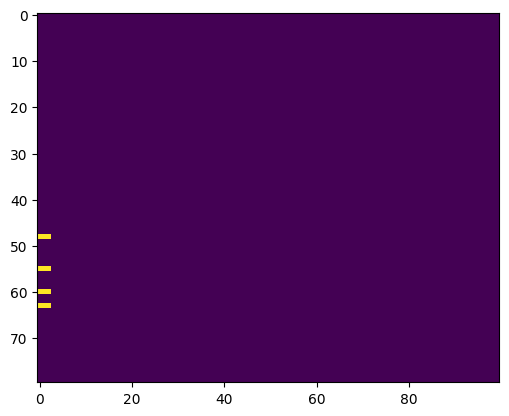

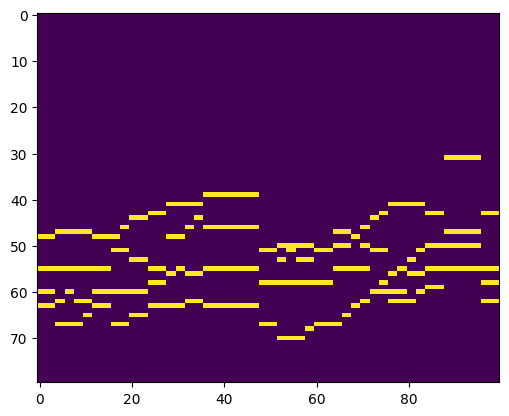

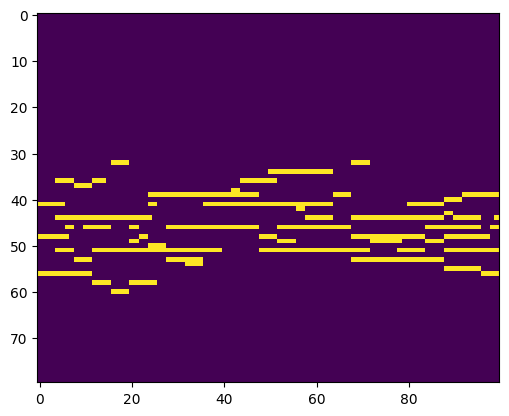

In [151]:
seed = torch.tensor(seeder, device=device).float().permute(0, 2, 1)[:, :L, :]
seed[seed > 0] = 1
seed = seed*0
# this initialize with a chord spreaded out
seed[0, 0:3, 57-16] = 1
seed[0, 0:3, 60-4] = 1
seed[0, 0:3, 64-16] = 1



generated_roll = autoregressive_sample(model, seed, max_steps=100)
print(generated_roll.shape)
plt.imshow(seeder[0])
plt.show()
plt.imshow(seedi[0])
plt.show()
plt.imshow(generated_roll[0].permute(1, 0).cpu())

In [52]:
# EXPAND A PIANOROLL TO 128 PITCH (NEEDED for the synthesis function)
def to_128(x):
    mapped = torch.zeros((128, x.shape[1]))
    mapped[10:90, :] = x
    return mapped

In [57]:
# FUNCTIONS
!pip install pretty_midi
import pretty_midi
S = 1
def S_to_pitch(pitch):
    return pitch + (S-1) if pitch % 2 == 1 else pitch

def multi_hot_to_midi(piano_roll: np.ndarray, time_per_step: float = 0.1,
                      velocity: int = 100) -> pretty_midi.PrettyMIDI:
    print(piano_roll.shape)
    T, n_pitches = piano_roll.shape
    if n_pitches != 128:
        raise ValueError("The input piano roll must have 128 columns (for MIDI notes 0-127).")

    midi_obj = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)

    active_notes = {}

    for t in range(T):
        current_time = t * time_per_step
        current_frame = piano_roll[t]  # shape: (128,)

        for pitch in range(128):
            is_active = current_frame[pitch] > 0
            prev_active = piano_roll[t - 1][pitch] > 0 if t > 0 else False

            if is_active and not prev_active:
                active_notes[pitch] = current_time
            elif not is_active and prev_active:
                start_time = active_notes.pop(pitch, current_time)
                note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+5, start=start_time, end=current_time)
                instrument.notes.append(note)

    final_time = T * time_per_step
    for pitch, start_time in active_notes.items():
        note = pretty_midi.Note(velocity=velocity, pitch=S_to_pitch(pitch)+5, start=start_time, end=final_time)
        instrument.notes.append(note)

    midi_obj.instruments.append(instrument)
    return midi_obj

def midi_to_audio(midi_path, fs=44100, tempo=100, autoplay=False):
    pm = midi_path                                                

    wav = pm.synthesize(fs)                                          
    wav = wav / np.max(np.abs(wav))                                  
    return Audio(wav, rate=fs, autoplay=autoplay)   

import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

def plot_midi_pianoroll(midi_path, fs=100):
    pm = midi_path
    
    piano_roll = pm.get_piano_roll(fs=fs)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r', 
               extent=[0, piano_roll.shape[1] / fs, 0, 128])
    plt.xlabel('Time (s)')
    plt.ylabel('MIDI Pitch')
    plt.title('Piano Roll')
    plt.colorbar(label='Velocity')
    plt.tight_layout()
    plt.show()

torch.Size([1, 100, 80])
torch.Size([128, 100])
(100, 128)


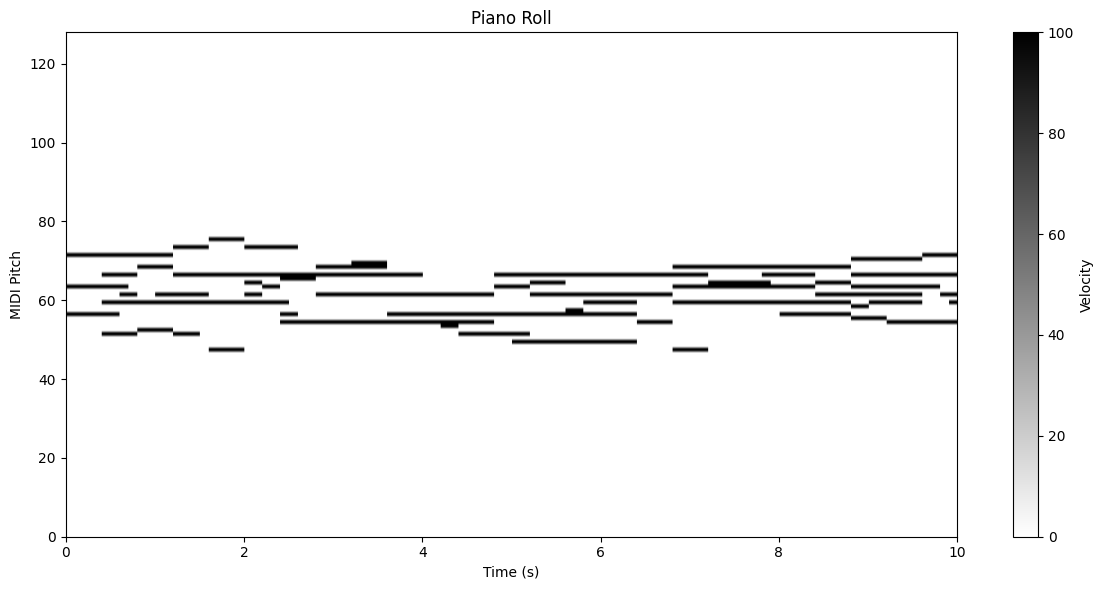

In [152]:
print(generated_roll.shape)
_sample = to_128(generated_roll[0].permute(1, 0).cpu())
print(_sample.shape)
midi = multi_hot_to_midi(_sample.cpu().numpy().T)
plot_midi_pianoroll(midi)
from IPython.display import Audio
midi.write('bachfromergen.mid')
midi_to_audio(midi)

In [125]:
torch.save(model, "BachB2.pt")